In [1]:
from notebook.services.config import ConfigManager
cm = ConfigManager()
cm.update('livereveal', {
        'width': 1920,
        'height': 1080,
        'scroll': True,
})
%config InlineBackend.figure_format = 'retina'

# Week 07, ASTR 596: Fundamentals of Data Science


## Posterior Predictive Checks, and connecting the Bayesian and Frequentist Worlds
#### (not on your midterm)

### Gautham Narayan 
##### <gsn@illinois.edu>

# <center> How is the Midterm going? </center>


## <center> What questions do you have? </center>

## Recap: 

<table>
    <tr>
        <td><img src="review.png" width=100%></td>
    </tr>
</table>

## <center> What do you feel least comfortable with? (Remember the stats dept. offers semester long courses on any of these topics!) </center>

## Recap:

We've talked about:
* Rejection sampling
* **Metropolis-Hastings**
    * Random walks are robust but inefficient - suppress random walk behavior to improve efficiency at the cost of complexity (interpretability) and applicability 
* The behavior or MCMC (burnin, autocorrelation, impact of starting position, if things are stationary...)
* How to tell if samples were useful (mixing chains, G-R statistic, number of effective samples, **looking at your data**) 

## Recap:

More useful MCMC tools:
* **Affine-invariant MC** (emcee) - works great as long as posterior is "nice" after affine transformation
    * counter-examples: Rosenbrock function, eggbox 
* **Parallel-tempering** (now, ptemcee) - adds chains at multiple temperatures (we care about T=1) 
    * connection to simulated annealing
    * computationally more intensive, even with a low number of dimensions
* **Gibbs Sampling** (special choice of prior, but if applicable to your problem, acceptance fraction = 1.)
    * connection to probability integral transform 
    * not very general, but most common way to deal with high dimensional spaces 
* Useful if overlooked - **you don't have to update all of the parameters of your model the same way**
    * i.e. you can look up something like **Metropolis within Gibbs**

## Recap:    
    
* All of these are specializations of MH (different starting positions, different number of chains, different proposals distributions) 
    * **None require evaluation of derivatives** - which is the general situation you'll be in with astrophysics
    * There are packages that will do automatic differentiation for you (e.g. `pymc3` which uses `theano`, `tensorflow`), but these can be "fragile" with real data

## Big Picture: Frequentist Statistics

* **Frequentists** make statements about the data (or statistics or estimators= functions of the data), conditional on the parameter: 

# $$p(D|\theta) \mathrm{\;or\;} p(f(D) |\theta)$$

* The goal is to get a “point estimate” or confidence intervals with good properties/coverage under “long-run” repeated experiments in the magic wonderland of Asymptopia.
    * Confidence intervals - arguments are based on datasets that could have happened but didn't.

## Big Picture: Bayesian Statistics

* Bayesians make statements about the probability of parameters conditional on the dataset $D$ that you actually observed

# $$p(\theta|D)$$

* This requires an interpretation of probability as a quantifying degree of belief in a hypothesis. This exists without any data even - i.e. **the prior**
    * Credible regions - arguments are based on variables you wish you observed but didn't (nuisance parameters/latent variables) 
    * This is not an equivalent shortcoming to the frequentist approach - it actually matches how reality works

## Big Picture: MCMC

* The Bayesian answer is the full posterior density, quantifying the "state of knowledge" after seeing the data
    * The likelihood is not a probability density in the parameters.
        * But multiply by a prior (even flat) and the posterior is a probability that obeys clear rules:
            * Conditional/Marginal probability
* **Numerical estimates (such as samples using Monte Carlo methods) are attempts to (imperfectly) summarize the posterior**
    * These techniques give us ways to deal with high-dimensional spaces e.g. many latent variables
        * Convert messy integrals to simple sums over samples
            * **All those frequentist statistics/estimators are still useful given MCMC samples!**

    
## Advice: MCMC

* MCMC is a terrible optimizer. If you just want the "best-fit", some local/global optimizer is often quicker.
    * These are often useful for reasonable starting guesses
    * Bayesians will often need to introduce latent variables/nuisance parameters/things you don't observe but wish you did 
        * YOU SHOULD THINK ABOUT THIS FOR Q3 ON THE MIDTERM!!! 
            * Coming up with the likelihood is not the same as writing down the model
    * These parameters make the problem very high dimensional, even if you don't care about them
    * The point of it is to sample the full posterior distribution so you have reasonable **credible regions**
        * You are scientists and this is what you actually want
            * **You write down the model and likelihood, and the Bayesian framework tells you what distribution of parameters is feasible given your data and your prior belief**

# For Fun: MCMC sampler visulations for different functions, without an annoying soundtrack:

# <center>[http://chi-feng.github.io/mcmc-demo/](http://chi-feng.github.io/mcmc-demo/)</center>

(There is only so many times you can listen to the Harlem shake - Hungarian dances for sorting algorithms are more fun)

## Posterior-predictive checks

* Nothing about the Bayesian framework we've discussed tells us if our model is right
    * MCMC can give us very precise, but very wrong inferences, if the model itself is inadequate
     
     
Let's look at the posterior again
## $$ P(\theta|D) \mathrm{\; is \; really \;} P(\theta|D, H) $$ 
i.e. assuming the hypothesis $H$ is itself correct.

## Posterior-predictive checks

Frequentists have a way to express the question we're asking

## $$P(D|H)$$
i.e. "how likely is the data given the hypothesis", which is similar to but not exactly the same as  "how likely is the data given the model parameters of this hypothesis"

The two are related though!

## $$P(D|H) = \int_{\theta} P(D|\theta) \cdot P(\theta|H)$$

This is the **predictive distribution** - the distribution of imaginary datasets if the hypothesis/model is true.

* i.e. if you have some observations $y_D$, and you can infer a model and then ask what we would expect to see in hypothetical replications of the same experiment.

* if the model is right, you expect to see something similar to what you did the first time

## Posterior-predictive checks

* THIS IS A FREQUENTIST IDEA!
* The idea is to generate data from the model using parameters from draws from the posterior.

## Big picture

* Bayes theory is needed to *estimate* parameters, conditional on observations and a model we are considering
* Frequentist theory is needed to *critique* a model conditioned on the data we observe, by exploring if the model actually is *likely* to generate data like our observations in the first place

## In Class Exercise:

We'll use our data from HW2 to try posterior predictive checks on a simple linear model.

In [2]:
# RUN THIS

%matplotlib inline
import numpy as np
import scipy.stats as st
from matplotlib import pyplot as plt
import scipy.optimize
from astroML.datasets import fetch_hogg2010test
import pymc3 as pm

In [3]:
# AND THIS

# Get data: this includes outliers
data = fetch_hogg2010test()
x = data['x']
y = data['y']
dy = data['sigma_y']

# convert the data to numpy arrays
x  = np.array(x)
y  = np.array(y)
dy = np.array(dy)

<ErrorbarContainer object of 3 artists>

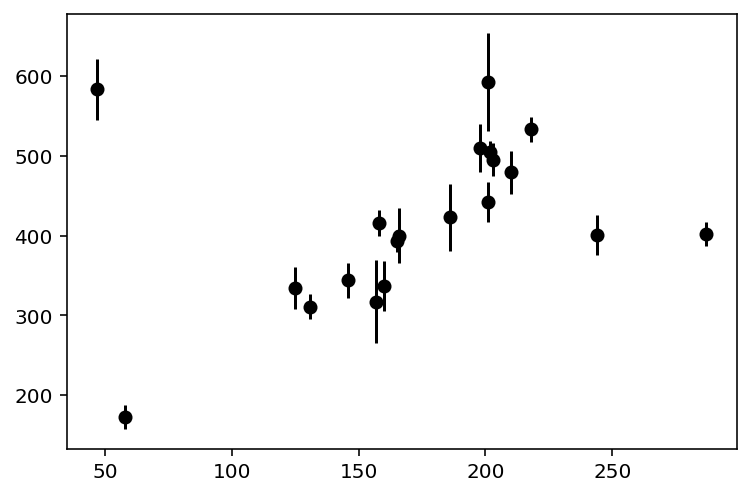

In [4]:
# We can check that the data is what we've already seen
# And you should definitely be looking at this and making a 
# qualitative comparison to the Cepheid data on your midterm
errorbar(x, y, yerr=dy, linestyle='None', color='k', marker='o')

# Next, we're going to use `pymc3` to fit this model, but we're going to be naive and use a Gaussian likelihood, despite knowing there are outliers.

In [5]:
with pm.Model() as model:
    # write down expressions for the priors on the slope and intercept of the line 
    
    # https://docs.pymc.io/api/distributions/continuous.html
    # they are all in the form of 
    # Distribution('variable name', parameters of distribution)
    # e.g. Normal('blah', mu=0, sigma=1)
    m = pm.Normal('m', mu=2, sigma=5)
    b = pm.Normal('b', mu=60, sigma=70)

    # write down your model
    ymod = m*x + b

    
    # and write down your likelihood function
    # pymc3 accepts keywords, observed for the data
    likelihood = pm.Normal('likelihood', mu=ymod, sigma=dy, observed=y)

    
    # and then to sample!
    samples_ols = pm.sample(5000, cores=2) # draw 5000 posterior samples 

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [b, m]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:11<00:00, 950.89draws/s] 
The number of effective samples is smaller than 25% for some parameters.


# Next make a traceplot of your samples

/Users/gnarayan/miniconda3/envs/fds/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/gnarayan/miniconda3/envs/fds/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/gnarayan/miniconda3/envs/fds/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/gnarayan/miniconda3/envs/fds/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs ha

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c2b223c10>,
      dtype=object)

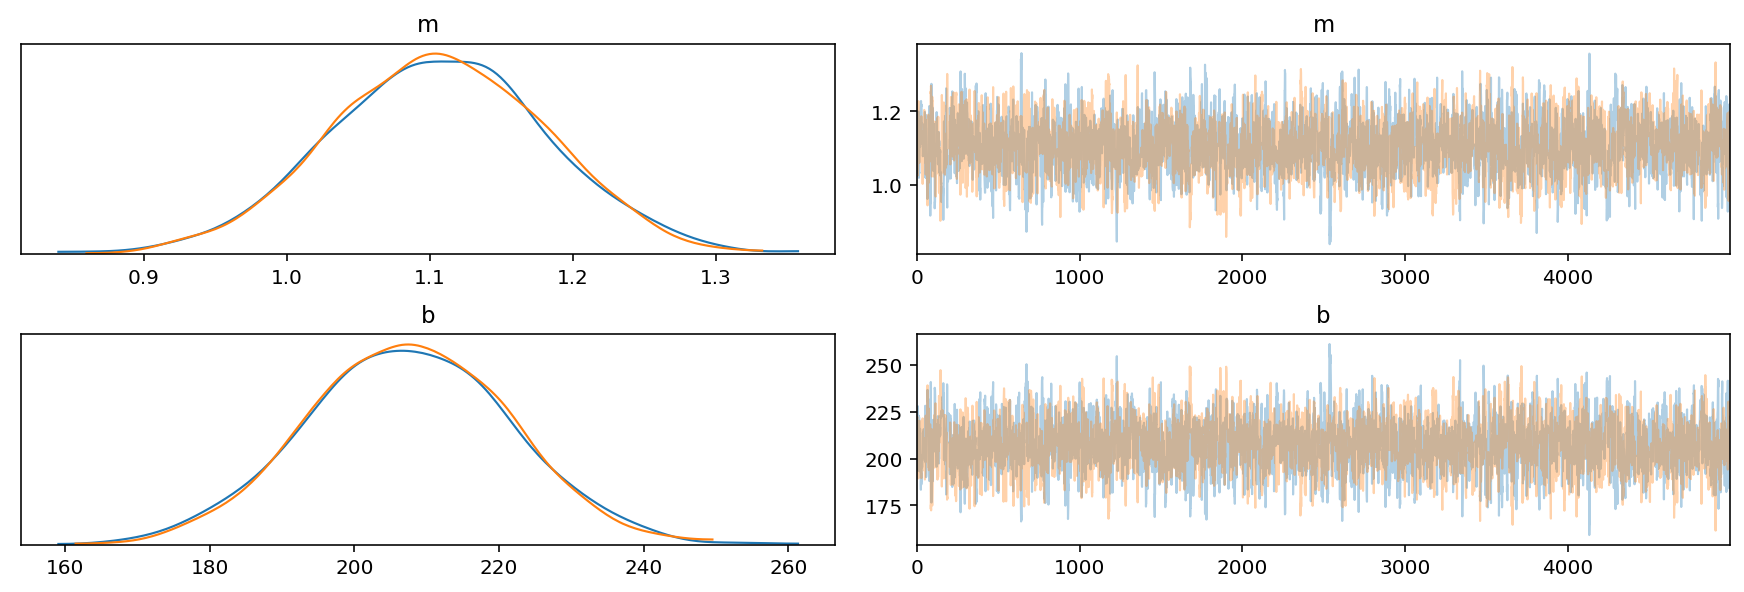

In [6]:
# You could use matplotlib and look at each variable in your chain
# but pymc3 is much more user friendly and lets you do traceplots quickly
pm.traceplot(samples_ols)

# If your traceplot looks ok, get some summary statistics from your trace

In [7]:
# you could also do something like np.percentile(samples_ols['m'], [16, 50, 84]) to get statistics
# but pymc3 is really user friendly so:
pm.summary(samples_ols)

/Users/gnarayan/miniconda3/envs/fds/lib/python3.7/site-packages/pymc3/stats.py:991: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  axis=1, join_axes=[dforg.index])


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
m,1.106158,0.074708,0.001727,0.960808,1.251334,1939.435425,0.999902
b,207.425744,13.922696,0.321449,178.981175,233.604749,2018.261111,0.999902


# Now lets see how if our data looks anything like data generated from the model suggest

In [8]:
# RUN THIS
ppc = pm.sample_posterior_predictive(samples_ols, samples=500, model=model)

100%|██████████| 500/500 [00:00<00:00, 1144.91it/s]


# Next we're going to try an alternative model, where our likelihood is a Student-T distribution rather than a Normal one. The Student-T remember has fatter tails than a Gaussian, so there is a higher probability of points being farther out - i.e. it's resilient to outliers. 

# It is characterized by a number of degrees of freedom, $nu$. This is *NOT* the number of degrees of freedom of the problem but rather a nuisance parameter that allows the tails of the distribution to be thinner/fatter.

# Since this is a parameter, it needs a prior. 

# It can't be less that 0 (or really less than 1, where the Student-T has infinite variance). We also know that $nu$ can't be really high, because in that limit the Student-T looks like a Gaussian, which would imply no outliers, and we know there are from just *looking at the data*.

# I picked a HalfCauchy distribution - you can pick something else if you like.

# Colin also suggested that the slope isn't negative, so we could use a Half-normal if we like. Half-Normals are defined like a Normal centered at 0 with the left half truncated, which isn't what we want, but we can add a bound to a standard normal distribution with some $\mu$ - I've bounded it at 2 in this example -i.e. we know that Colin is right and the slope is higher than 2. 

In [9]:
import theano.tensor as tt

with pm.Model() as model2:
    # write down expressions for the priors on the slope and intercept of the line 
    
    # https://docs.pymc.io/api/distributions/continuous.html
    # they are all in the form of 
    # Distribution('variable name', parameters of distribution)
    # e.g. Normal('blah', mu=0, sigma=1)
    
    b = pm.Normal('b', mu=60, sigma=70)
    m = pm.Bound(pm.Normal, lower=2)('m', mu=2.0, sigma=5.0)
    nu = pm.HalfCauchy('nu', beta=3)

    # write down your model
    ymod = m*x + b

    
    # and write down your likelihood function
    # pymc3 accepts keywords, observed for the data
    likelihood = pm.StudentT('likelihoodT', mu=ymod, nu=nu, sigma=dy, observed=y)

    
    # and then to sample!
    samples_T = pm.sample(5000, cores=2) # draw 5000 posterior samples 

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, m, b]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:15<00:00, 701.42draws/s]
The acceptance probability does not match the target. It is 0.7167549211379226, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.7016342606330543, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.


# Note how the posterior distribution in the slope $m$ looks now! 

/Users/gnarayan/miniconda3/envs/fds/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/gnarayan/miniconda3/envs/fds/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/gnarayan/miniconda3/envs/fds/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/gnarayan/miniconda3/envs/fds/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs ha

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c2cb78890>,
      dtype=object)

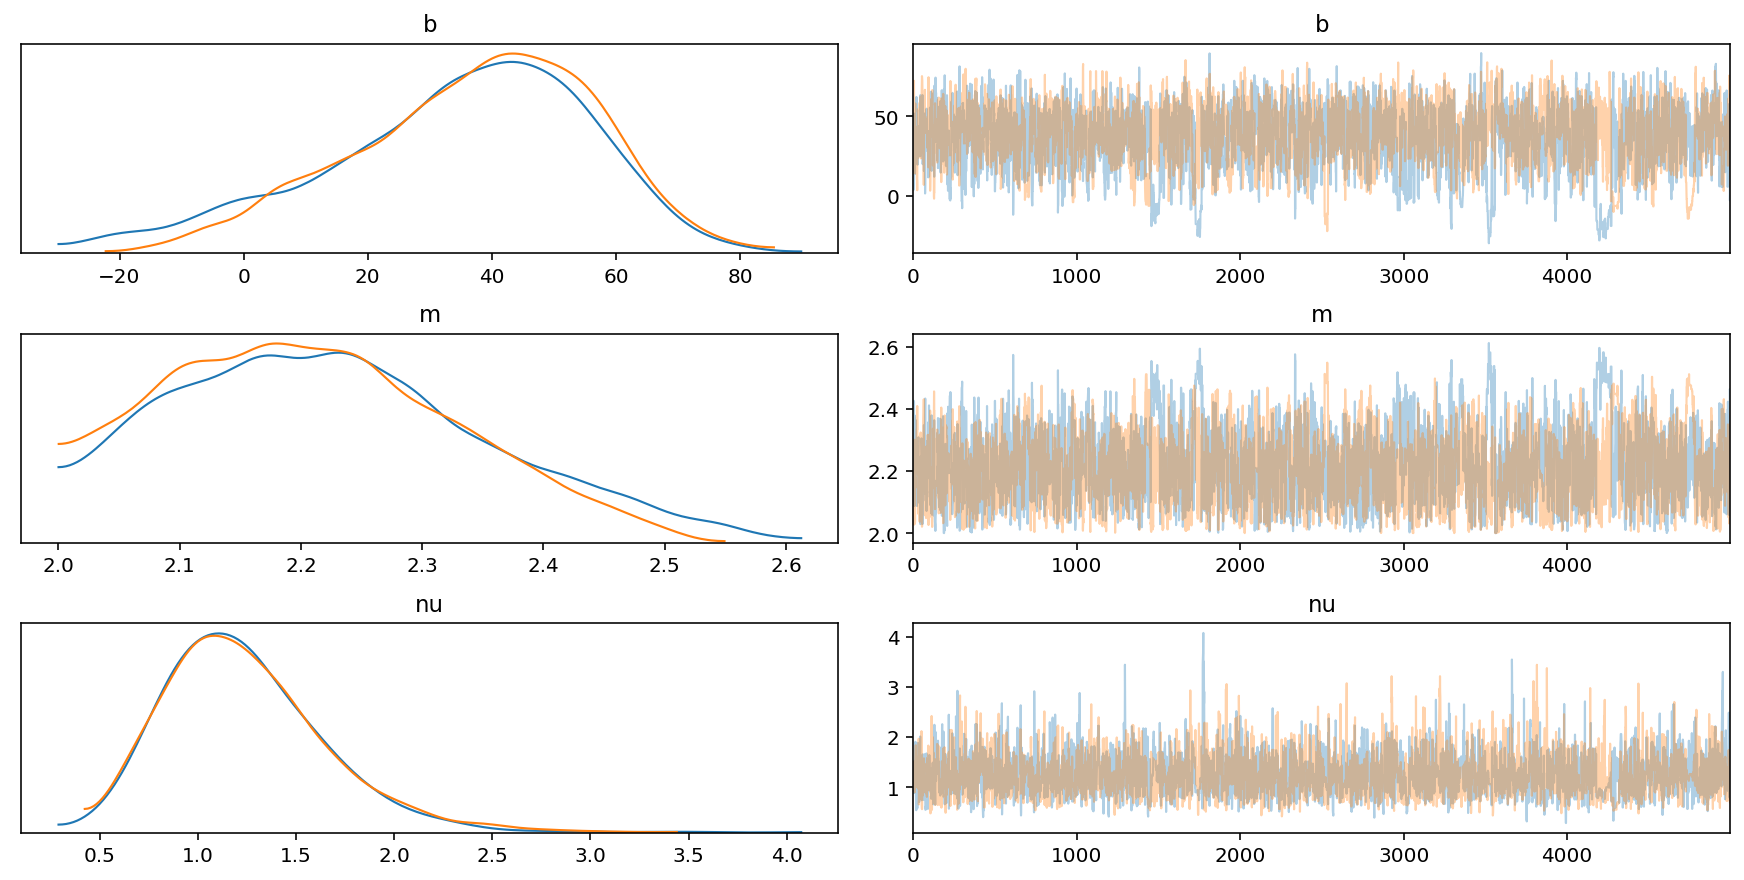

In [10]:
pm.traceplot(samples_T)

# As before we generate posterior predictive samples - i.e. samples that are generated, drawing from the posterior distribution.

In [11]:
ppcT = pm.sample_posterior_predictive(samples_T, samples=500, model=model2)

100%|██████████| 500/500 [00:00<00:00, 888.86it/s]


(123.83470283070778, 629.166216735859)

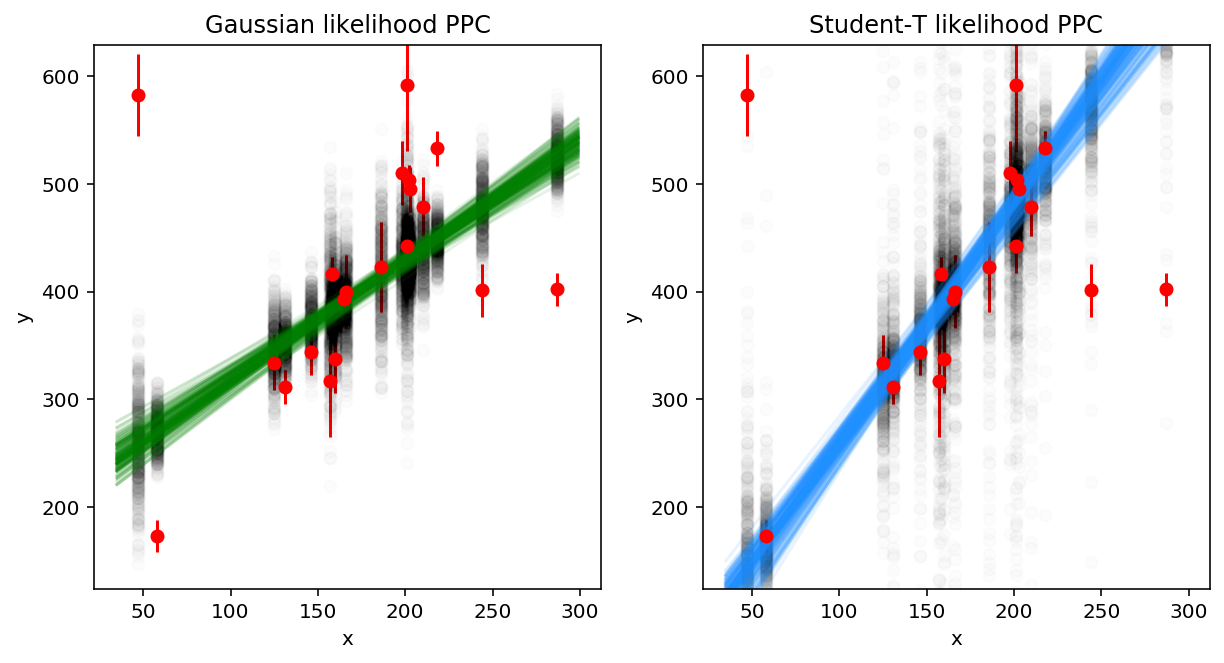

In [12]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(121)
ax2 = fig.add_subplot(122, sharex=ax, sharey=ax)


# draw 200 random samples from the posteriors
nsamp = 200
i = np.random.choice(range(samples_ols['m'].shape[0]), size=nsamp)
m = samples_ols['m'][i]
b = samples_ols['b'][i]

m2 = samples_T['m'][i]
b2 = samples_T['b'][i]

# plot the posterior predictive samples for the Gaussian
for i in range(ppc['likelihood'].shape[0]):
    ymod = ppc['likelihood'][i,:]
    ax.plot(x, ymod, 'ko', alpha=0.01)
    
xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()
  
# plot the posterior predictive samples for the student T
for i in range(ppcT['likelihoodT'].shape[0]):
    ymod = ppcT['likelihoodT'][i,:]
    ax2.plot(x, ymod, 'ko', alpha=0.01) 

xarr = np.array([xmin, xmax])
for mx, bx in zip(m, b):
    ax.plot(xarr, mx*xarr + bx, alpha=0.1, color='green')
    
for mx, bx in zip(m2, b2):
    ax2.plot(xarr, mx*xarr + bx, alpha=0.1, color='dodgerblue')
    
    
ax.errorbar(x, y, yerr=dy, linestyle='None', color='red', marker='o')
ax2.errorbar(x, y, yerr=dy, linestyle='None', color='red', marker='o')

ax.set_title('Gaussian likelihood PPC')
ax2.set_title('Student-T likelihood PPC')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax2.set_xlabel('x')
ax2.set_ylabel('y')

ax2.set_ylim([ymin, ymax])

## You should be able to see that the posterior predictive samples from the Student-T model are a much better match to the real observations - there's more outliers, like we actually get, but they don't weight the fit as much so the slope is more reasonable. 



## [PyMC3 implementation of the Outlier model we used with `emcee`](https://docs.pymc.io/notebooks/GLM-robust-with-outlier-detection.html)

(Feel free to use on your midterm if you prefer)